# <p id="top">Creating and Adjusting the WCS</p>
***

Some references: [AstroPy - Building a WCS](https://docs.astropy.org/en/stable/wcs/#building-a-wcs-structure-programmatically) and [FITS standard definition](https://fits.gsfc.nasa.gov/standard40/fits_standard40aa-le.pdf) (WCS: Section 8). 

Outline:

1. <a href="#1">Building a WCS</a>
2. <a href="#2">Rotating existing WCS</a>
3. <a href="#3">Translating existing WCS horizontally or vertically</a>
4. <a href="#4">Test</a>
5. <a href="#5">Saving the new WCS</a>

#### Imports:

In [15]:
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.visualization import AsinhStretch, AsymmetricPercentileInterval
norm = AsymmetricPercentileInterval(1, 99.7)

***
#### Some background about WCS

In general, WCS transforms a pixel value to a sky coordinate in 2 steps:
1. Linear transformation: take a pixel value $\vec{x}_{px} = (x, y)$ and translate / rotate it wrt reference pixel $\vec{x}_{ref}$ to match the WCS position and angle. This makes an *intermediate world coordinate* $\vec{x}_{sky}$. **This is the step important to us**


$$ \vec{x}_{sky} = s R_{ij} \big( \vec{x}_{px} - \vec{x}_{ref} \big)$$

* The horizontal/vertical offset is defined in $\vec{x}_{px} - \vec{x}_{ref}$
* Rotation by angle $\alpha$ is defined by rotation matrix $R_{ij}$

$$R_{ij} =
\begin{pmatrix}
\cos{\alpha} & -\sin{\alpha}\\
\sin{\alpha} & \cos{\alpha}
\end{pmatrix}$$
* Image scale is given by $s$: pixel scale in degrees / pixel

<br>
2. Non-linear transformation: transform $\vec{x}_{sky}$ to match the curvature of the chosen CS (e.g. equatorial, galactic etc). The coordinate system is set in the WCS; and we don't need to mess with this transformation

***



## <p id="1">1. Build a new WCS</p>

<a href="#top">Back to top</a><br>

This is mostly taken from the AstroPy guide. Builds a spatial WCS (a spectral axis can be added, but I haven't done it because I'm not familiar with spectral WCS...)

***


* **Reference pixel and coordinate.** Given by (`xcent`, `ycent`) and (`ra`, `dec`) respectively. Gives the coordinate value of a pixel, "tying" WCS to a place on the sky. The reference coordinate can be anywhere inside or outside the image; but rotations are done wrt the reference pixel, so they are most intuitive when the reference pixel is in the image center.
<br>

* **Rotation Matrix.** Defined by angle `angle` (in deg) and pixl scale of the image `pxscale` (in arcsec/pixel). There are 2 options:
    1. **PC matrix** (used here): $\textrm{PC} = s R_{ij}$ so it combines scaling and rotation of the image. 
    2. **CD matrix**: the pixel scale is given by a different `CDELT = [dx, dy]` keyword, and the `CD` matrix corresponds to just the rotation. This is cleaner but I'm not 100% confident with using it, so I used the PC.
    
***

<font color="red">**Python caveat**</font>: in Python, 2D image array indices are in the order [y, x] instead of [x, y]. So the WCS rotation matrix is actually different:

$$ \textrm{PC} = s \times \begin{pmatrix}
-\sin{\alpha} & \cos{\alpha}\\
\cos{\alpha} & \sin{\alpha}
\end{pmatrix}$$

This way, $\textrm{PC} \times [y, x]$ gives the right transformation, e.g. $\textrm{ra} = x \cos{\alpha} - y\sin{\alpha} $

In [2]:
def make_wcs(xcent, ycent, ra, dec, pxscale, angle=90, naxis=2):
    """Makes a WCS using a reference pixel given by (x, y) at (ra, dec), 
    and a pixel scale of the image. The rotation is done wrt the reference pixel, so it's easiest to define
    central pixel as the reference one.
    By default, makes a north-aligned J2000 2-d WCS. Can convert this to a fits header using wcs.to_header(). 
    Reference: https://docs.astropy.org/en/stable/wcs/
    https://fits.gsfc.nasa.gov/standard40/fits_standard40aa-le.pdf
    
    INPUTS:
        xcent, ycent    = pixel coordinates of the ref. pixel (preferred: image center)
        ra, dec = physical coordinates of the ref. pixel
        pxscale = pixel scale of the image (in arcsesc/px)
    OPTIONAL:
        angle = rotation angle in degrees; default: 90 (aligned with North)
        naxis = number of axes; default: 2 (set to 3 for spectral cube)
        ...not sure how spectral WCS work so work in progress
    RETURNS:
        wcs: astropy WCS object
    """
    
    # Create a new WCS object.  The number of axes must be set from the start
    w = WCS(naxis=naxis)
    
    # Set up the reference coordinates
    w.wcs.crpix = [xcent, ycent]   # Reference pixel corresponding to ra, dec from crval
    w.wcs.crval = [ra, dec]
    
    # Rotation matrix
    th      = angle*np.pi/180
    rot_mat = np.array([[-np.sin(th), np.cos(th)], [np.cos(th), np.sin(th)]])
    
    # PC matrix = Pixel Scale * Rotation matrix
    pxscale  = pxscale / 3600    # convert arcsec/px to deg/px
    w.wcs.pc = pxscale * rot_mat
    
    # Coordinate type: default
    w.wcs.ctype = ["RA---TAN", "DEC--TAN"]
    
    return w

## <p id="2">2. Rotate given WCS by an angle</p>

<a href="#top">Back to top</a><br>

To rotate by some angle $\alpha'$, we want to transform the old $\textrm{PC}$ matrix into the new $\textrm{PC}'$ with transformation matrix $T(\alpha')$ so that

$$\textrm{PC}_{new}' = \textrm{PC}'(\alpha + \alpha') = T(\alpha') \times \textrm{PC}(\alpha) $$

with some double angle formulae magic (probably unnecessary but I wanted to make sure) turns out T is just a rotation matrix:

$$T(\alpha') =  \begin{pmatrix}
\cos{\alpha'} & -\sin{\alpha'}\\
\sin{\alpha'} & \cos{\alpha}
\end{pmatrix}$$

<font color="red">**TIL:**</font> turns out Python's `*` does element-wise, not matrix, multiplication, so we need to use `dot` here. This bug took forever to catch.....

In [3]:
def rotate_wcs(angle, wcs):
    """Rotates the WCS by an angle (given in degrees)""" 
    th          = angle*np.pi/180   # Convert to radians
    new_wcs     = wcs.deepcopy()    # Copy input WCS so that it's not overwritten
    
    # Multiply PCs by a rotation matrix
    rotation       = np.array([[np.cos(th), -np.sin(th)], [np.sin(th), np.cos(th)]]) 
    new_wcs.wcs.pc = rotation.dot(wcs.wcs.pc)
    return new_wcs

## <p id="3">3. Move WCS horizontally / vertically</p>
<a href="#top">Back to top</a><br>

The horizontal/vertical offset is just defined by the reference pixel, so all we need to change is the reference pixel. Given  $\Delta x$ and $\Delta y$, we calculate $\Delta \textrm{ra}$ and $\Delta \textrm{dec}$:

$$ \begin{pmatrix}\Delta \textrm{ra} \\ \Delta \textrm{dec} \end{pmatrix} = \textrm{PC} \begin{pmatrix}\Delta y \\ \Delta x \end{pmatrix}$$

<font color="red">**...or that's what I thought**</font> but for some reason here actually the x and y are flipped to the normal direction, so we want to do $\textrm{PC} \times (\Delta x, \Delta y)$. No clue why

In [4]:
def move_wcs(dx, dy, wcs):
    """Given (dx, dy) in px, translate the image horizontally/vertically by changing the
    coordinate of the reference pixel"""
    
    # Figure out the change in the reference coordinates for given (dy, dx)
    pc      = wcs.wcs.pc
    d_crval = pc.dot(np.array([dx, dy])) 
    
    # Change the reference pixel's ra, dec 
    new_wcs       = wcs.deepcopy()
    new_crval     = wcs.wcs.crval + d_crval
    new_wcs.wcs.crval = new_crval
    return new_wcs

## <p id="4">4. Test!</p>
<a href="#top">Back to top</a><br>

Dummy array for the test:

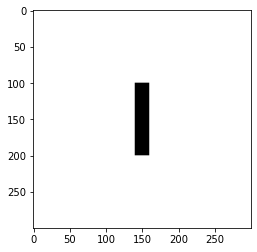

In [5]:
size = 300
arr  = np.zeros((size, size))
arr[100:200, 140:160] = 1
plt.imshow(arr, cmap="gray_r")

Make a WCS. We'll place this bar in NGC 1073! 
   * (ra, dec) = (40.91915, +1.3758)
   * Pixel scale = 0.258 arcscec / pixel
   * Rotation = 30 degrees (why not)

In [6]:
center = int(size/2)
wcs    = make_wcs(xcent=center, ycent=center, ra=40.9252, dec=1.385869, pxscale=0.3, angle=90)
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 40.9252  1.385869  
CRPIX : 150.0  150.0  
PC1_1 PC1_2  : -8.333333333333333e-05  5.1026949964473045e-21  
PC2_1 PC2_2  : 5.1026949964473045e-21  8.333333333333333e-05  
CDELT : 1.0  1.0  
NAXIS : 0  0

Plot the dummy array on a WCS projection this time. This isn;'t particularly interesting at the moment, but this code does two things:
* Create an axis with a projection given by WCS. This is a little misleading because the object is not North-aligned here. To align with North, set `angle=90` in the WCS.
* Plot the dummy array on the axis, by transforming between its WCS (given in `trasnform` keyword) into the `projection` WCS.
***
<font color="red">**Be careful**:</font> I used to have issues doing this for images with different pixel scales between the `transform` and `projection` coordinates. It seems to work now, but this may be a source of bugs.  If the pixel scale is different, `reproject` package can help

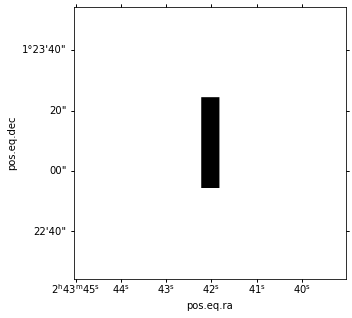

In [7]:
fig = plt.figure(figsize=(5,5))
ax  = plt.subplot(projection = wcs)
ax.imshow(arr, transform=ax.get_transform(wcs), alpha=1, cmap="gray_r", origin="lower")

We can plot our bar on the same axis as the actual NGC 1073:

In [8]:
galaxy  = fits.open("ngc1073.fits")
ngc_wcs = WCS(galaxy[0].header)

this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


(0.0, 700.0)

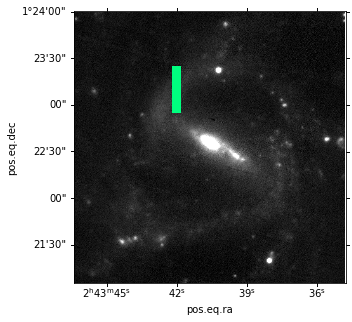

In [9]:
fig = plt.figure(figsize=(5,5))
ax  = plt.subplot(projection = ngc_wcs)

ax.imshow(norm(galaxy[0].data), transform=ax.get_transform(ngc_wcs), alpha=1, cmap="gray", origin="lower")
ax.imshow(arr, transform=ax.get_transform(wcs), alpha=arr, cmap="winter", origin="lower")

plt.xlim(0, galaxy[0].shape[1])
plt.ylim(0, galaxy[0].shape[0])

These are clearly not aligned! Let's move the bar a bit:

In [10]:
wcs_trans = move_wcs(70, -115, wcs)

(0.0, 700.0)

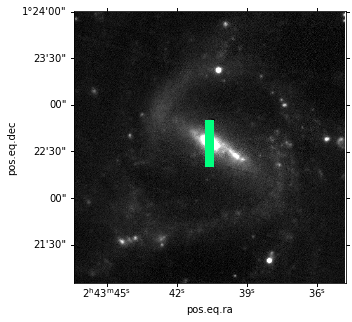

In [11]:
fig = plt.figure(figsize=(5,5))
ax  = plt.subplot(projection = ngc_wcs)

ax.imshow(norm(galaxy[0].data), transform=ax.get_transform(ngc_wcs), alpha=1, cmap="gray", origin="lower")
ax.imshow(arr, transform=ax.get_transform(wcs_trans), alpha=arr, cmap="winter", origin="lower")

plt.xlim(0, galaxy[0].shape[1])
plt.ylim(0, galaxy[0].shape[0])

Better, now we need to rotate it as well

In [12]:
wcs_rot = rotate_wcs(-50, wcs_trans)

(0.0, 700.0)

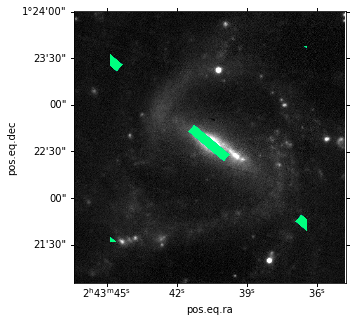

In [13]:
fig = plt.figure(figsize=(5,5))
ax  = plt.subplot(projection = ngc_wcs)

ax.imshow(norm(galaxy[0].data), transform=ax.get_transform(ngc_wcs), alpha=1, cmap="gray", origin="lower")
ax.imshow(arr, transform=ax.get_transform(wcs_rot), alpha=arr, cmap="winter", origin="lower")

plt.xlim(0, galaxy[0].shape[1])
plt.ylim(0, galaxy[0].shape[0])

This is almost right! But need to adjust the angle a little bit more.

**Weird artifacts at the edges:** honestly I don't know where they're coming from. My guess is that changing the PC matrix when rotating adds some degeneracy in angles maybe? I'm not sure. But when you save the data to a FITS file, these artifacts don't show up in ds9.

## <p id="5"> 5. Saving the new WCS </p>
<a href="#top">Back to top</a><br>

We can save the image and its WCS for later use (or plotting in ds9) as a FITS file:

In [14]:
header = wcs_rot.to_header()
file   = fits.PrimaryHDU(arr, header=header)
file.writeto("test.fits", overwrite=True)